In [1]:
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.interpolate import BSpline

from cvi.slice import CviNode, CviRealParams, CviSlice

## Replicate graphs from paper

#### Basis functions

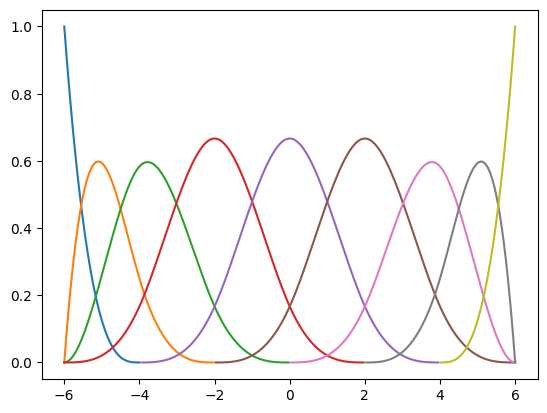

In [2]:
locs = [-6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0]
knots = [locs[0]] * 3 + locs + [locs[-1]] * 3
degree = 3

basis_funcs = [
    BSpline.basis_element(knots[i : i + degree + 2], extrapolate=False)
    for i in range(len(knots) - degree - 1)
]

xs = np.linspace(knots[0], knots[-1] - 1e-6, num=200)
for basis_func in basis_funcs:
    plt.plot(xs, basis_func(xs))

#### Var, skew, curvature

0.52436s --- 0.00052s/it
0.19437s --- 0.00019s/it


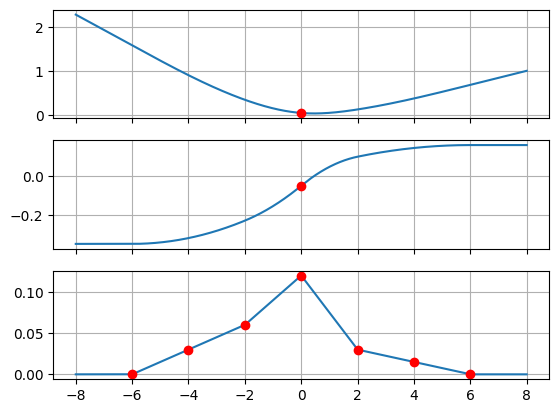

In [3]:
n_trials = 1000

log_mns = np.linspace(-8, 8.0, num=3000)
log_mns_coarse = np.array([-6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0])
strikes = 100 * np.exp(log_mns)
strikes_coarse = 100 * np.exp(log_mns)

start = time.perf_counter()
for i in range(n_trials):
    slc = CviSlice.from_real_params(
        CviRealParams(
            atm_var=0.2 * 0.2,
            skew=5.0,
            nodes=[
                CviNode(-6.0, 0.0),
                CviNode(-4.0, 0.03),
                CviNode(-2.0, 0.06),
                CviNode(0.0, 0.12),
                CviNode(2.0, 0.03),
                CviNode(4.0, 0.015),
                CviNode(6.0, 0.0),
            ],
        ),
        ref_fwd=100.0,
        t_e=1.0,
    )
    
    vols = slc.var_deriv1_deriv2_z(log_mns)
    vols_coarse = slc.var_deriv1_deriv2_z(log_mns_coarse)
end = time.perf_counter()
print(f"{end - start:.5f}s --- {(end - start) / n_trials:.5f}s/it")


# We compare how long it takes the CVI slice to compute vols vs a scipy CubicSpline.
# Our CVI slice is roughly 2.5 times slower.
# If memory serves, calculating cubic spline params (in the regular Natural Cubic Spline case as below)
# is a lower triangular matrix solving problem while in the CVI case, we are solving a tridiagonal 
# matrix problem. We have not yet optimized the calculation so we are actually doing a full matrix inversion.
# Though in this case the matrices are so small that it probably doesn't matter.
# Creating numpy arrays takes ridiculously long so it might just be that poor usage of numpy. TBD.
start = time.perf_counter()
for _ in range(n_trials):
    slc = interpolate.CubicSpline(log_mns, vols[0])
    vols2 = slc(log_mns)
end = time.perf_counter()
print(f"{end - start:.5f}s --- {(end - start) / n_trials:.5f}s/it")

fig, ax = plt.subplots(3, 1, sharex="all")
ax[0].plot(log_mns, vols[0])
ax[0].plot(log_mns_coarse[3], vols_coarse[0][3], "ro")
ax[0].grid()
ax[1].plot(log_mns, vols[1])
ax[1].plot(log_mns_coarse[3], vols_coarse[1][3], "ro")
ax[1].grid()
ax[2].plot(log_mns, vols[2])
ax[2].plot(log_mns_coarse, vols_coarse[2], "ro")
ax[2].grid()
plt.show()

x = 1


## Fitting (IGNORE FOR NOW - UNDER CONSTRUCTION)

In [4]:
from cvi.option_chain import OptionChain
from pandera.typing import DataFrame
import pandas as pd

In [5]:
chain = DataFrame[OptionChain](pd.read_csv("cvi/examples/data/2023-04-14_vol.csv"))

In [6]:
chain["expiry"].iloc[0]

'2023-04-14 16:00:00'

In [7]:
import numpy.typing as npt

In [8]:
import numpy as np

np.ones(5)

array([1., 1., 1., 1., 1.])

In [9]:
np.array([[1, 2, 3], [4, 5, 6]]).shape

(2, 3)

In [10]:
import pandas as pd
import numpy as np
from pandera.typing import DataFrame

from cvi.slice import *
from cvi.fitter import CviVolFitter, CviVolFitterOptions
from cvi.option_chain import OptionChain

slc = CviSlice.from_real_params(
    CviRealParams(
        atm_var=0.2 * 0.2,
        skew=5.0,
        nodes=[
            CviNode(-6.0, 0.0),
            CviNode(-4.0, 0.03),
            CviNode(-2.0, 0.06),
            CviNode(0.0, 0.12),
            CviNode(2.0, 0.03),
            CviNode(4.0, 0.015),
            CviNode(6.0, 0.0),
        ],
    ),
    ref_fwd=100.0,
    t_e=1.0,
)

chain = DataFrame[OptionChain](pd.read_csv("cvi/examples/data/2023-04-14_vol.csv"))

fitter = CviVolFitter()
opts = CviVolFitterOptions(weighting_least_sq="vol_spread")
node_locs = [-20.0, -15.0, -10.0, -8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0, 20.0]
df = fitter.fit(chain, node_locs, opts)

NotImplementedError: multi-dimensional sub-views are not implemented

In [ ]:
from scipy.sparse import bsr_matrix

df1 = df.iloc[0]
df2 = df.iloc[1]

indptr = np.array([0, 1, 2])
indices = np.array([0, 1])
data = np.array([df1, df2], dtype="object")

bsr_matrix(
    (data, indices, indptr), shape=(df1.shape[0] + df2.shape[0], df1.shape[1] + df2.shape[1])
).toarray()

NameError: name 'df' is not defined

In [3]:
from scipy.sparse import csr_matrix, bmat

num_cols = df1.shape[1] + df2.shape[1]
zero1 = csr_matrix((df1.shape[0], num_cols - df1.shape[1]))
zero2 = csr_matrix((df2.shape[0], num_cols - df2.shape[1]))

bmat([[df1, None], [None, df2]], format="csr")

NameError: name 'df1' is not defined

In [46]:
print(df1.shape)
print(zero1.shape)

print(df2.shape)
print(zero2.shape)

(8, 17)
(8, 34)
(103, 17)
(103, 34)


In [42]:
blocks.ndim

1

In [ ]:
x = np.array([1, 2, 3, 4, 5, 6]).repeat(4).reshape(6, 2, 2)
np.array(
    [
        np.array(
            [
                np.array([1, 1]),
                np.array([1, 1]),
            ]
        ),
        np.array(
            [
                np.array([2, 2, 2]),
                np.array([2, 2, 2]),
            ]
        ),
    ]
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

In [3]:
pd.DataFrame(df.iloc[0]).to_csv(r"c:\temp\vals.csv")

In [ ]:
import pandas as pd

chain = pd.

In [3]:
from scipy.interpolate import splev

x = np.linspace(-6.0, 6.0)
slc.spline_params.val_basis_funcs(x, 0)

# n = len(x)
# m = len(slc._spline_params.knots) - 4
# res = np.zeros((n, m))
# for i in range(m):
#     t = slc._spline_params.knots[i:i+5]
#     res[:, i] = splev(x, (t, 1.0, 3), der=0, ext=0)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [6.75798349e-01, 3.03087999e-01, 2.08076567e-02, 3.05994951e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [4.30543396e-01, 4.90509907e-01, 7.64987378e-02, 2.44795961e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.53219322e-01, 5.81543405e-01, 1.56975410e-01, 8.26186368e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.32810309e-01, 5.95466175e-01, 2.52139840e-01, 1.95836769e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [5.83005380e-02, 5.51555899e-01, 3.51894194e-01, 3.82493689e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0